In [1]:
import numpy as np
import cv2, random, sys, os, glob
from itertools import chain

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
from shutil import copyfile
copyfile(src = "../input/facedataset/FUNC_script.py", dst = "../working/FUNC_script.py")
from FUNC_script import *

In [3]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

### CONFIG

In [4]:
%%capture

totalSubjects= 5
mask= load_img('../input/facedataset/binary_glass_mask2.jpg')/255.0
imgDir= '../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/'
# Load FaceNet Model
model = load_model('../input/face-net-keras-model/facenet_keras.h5', compile= False)
model.trainable= False

# (index(0)==legitimate)
# (index((totalSubjects-1))== Adversarial)
subjects= ['s12', 's33', 's27', 's06', 's01']
subjectLabels=[]
subjectsDict= {k:[] for k in subjects}
target= subjects[0]

2022-01-19 06:48:13.910783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 06:48:14.034625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 06:48:14.035376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 06:48:14.036508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
def salt_2dim(X):
    samples, features= X.shape
    X_out= np.zeros((samples,features//2, 2))
    for i, x in enumerate(X):
        X_out[i,:, 0]= x[:features//2]
        X_out[i,:, 1]= x[features//2:]
    return X_out

def shuffle(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                np.random.seed(seed)
            np.random.shuffle(x[:8])
    return X_vec

# For Tensors
def shuffle_tesnsor(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                tf.random.set_seed(seed)
            tf.random.shuffle(x)
    return X_vec

def get_RDM(Fv, token=6, c=100):
    '''
    INPUT---
    Fv.shape: (None, feature)
    token: Uses token key
    PROCESS---
    1. Feature vector(Fv) multiplied by a large constant, say c = 100 due to its low dynamic range.
    2. To increase the entropy of the template, fv is salted by ORing it with a random grid RG as fs = fv + RG.
    3. Fv is divided into two equal parts.
    4. A user-specific key (K) of dimension 1 × N is generated, 
    which has randomly distributed non-integral values in the range [−100, 100].
    5. Computation of distance via random feature vectors.
    6. In order to provide noninvertibility, median filtering is applied on distance vector D
    to generate transformed feature vector T f , where the intensity
    values are shuffled in p ×1 neighborhood. T f is stored as the
    final transformed template.
    OUTPUT---
    Out.shape: (None, feature//2)
    '''
    #1
    #Fv*= c
    #2
    np.random.seed(token)
    Fv+= np.random.randint(1, 256, size= Fv.shape)
    #3
    Fv= salt_2dim(Fv)
    #4
    np.random.seed(token)
    K= np.random.randint(-100, 101, size= (1, Fv.shape[-1]))
    #5
    dist =(Fv- K)**2
    dist= np.sqrt(np.sum(dist, 2))
    #6
    Tf= shuffle(dist.copy(), p=4, seed= token, with_seed= True)
    return Tf


#for tensors
def RDM_tf(Fv, token=6, c=100.0):
  #Fv= tf.Variable(Fv, dtype=tf.float64)
  Fv+=c

  tf.random.set_seed(token)
  Fv+= tf.random.uniform(
      Fv.shape, minval=1, maxval=256, dtype=tf.dtypes.float64, seed=None, name=None)
  
  Fv= tf.convert_to_tensor(salt_2dim(Fv))
  tf.random.set_seed(token)
  K= tf.random.uniform((1, Fv.shape[-1]), minval=-101, maxval=101, dtype=tf.dtypes.float64, seed=None, name=None)

  dist =(Fv- K)**2
  dist= tf.math.sqrt(tf.math.reduce_sum(dist, 2))

  return shuffle_tesnsor(dist, p=4, seed= token, with_seed= True)

In [6]:
totSample=0
for sam in subjects:
    for path in glob.glob(imgDir+sam+'/*'):
        img= load_img(path, resize=160)
        img= model.predict(img[np.newaxis, :, :, :]/255.0)[0]
        subjectsDict[sam].append(get_RDM(img[np.newaxis, :], token= subjects.index(sam))[0])
        subjectLabels.append(subjects.index(sam))
        totSample+=1
totSample

2022-01-19 06:48:20.951040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 06:48:23.473525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50

In [7]:
flattened = np.array([val for sublist in list(subjectsDict.values()) for val in sublist])

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)

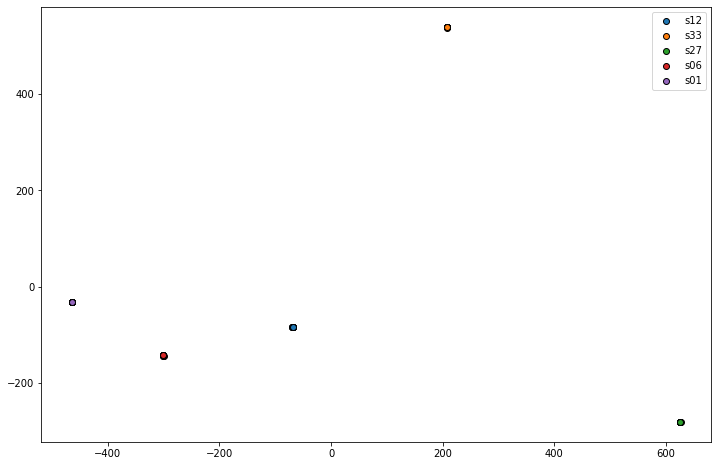

In [8]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [9]:
flattened.shape, len(subjectLabels)

((50, 64), 50)

In [10]:
from sklearn.cluster import KMeans
class kMeansModel:
    def __init__(self, n_class):
        self.n_class=n_class
        self.model= KMeans(n_clusters=self.n_class, random_state=0)
    def fit(self, data):
        self.model.fit(data)
        self.centers= self.model.cluster_centers_
        return self.model.labels_
    def predict(self, data, th=10):
        res=[]
        for d in data:
            arr= np.linalg.norm(self.centers-d, axis=1)
            #print(arr)
            if arr.min()<=th:
                ind= np.where(arr==arr.min())[0][0]
                res.append(ind)
            else:
                res.append(-1)
        return np.array(res)        

In [11]:
KMEANS= kMeansModel(totalSubjects)
KMEANS.fit(flattened)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

### Adversarial Centroid

In [12]:
# Data  Loading
def load_data(path):
    X=[]
    for i, sample in enumerate(path):
        image= load_img(sample)
        image = cv2.resize(image, (160, 160))
        X.append(image/255.0)
    return np.array(X)

# Loss
def loss_object(pred, label, delta_x, direction= False):
  # Loss= euclidean distance + Delta_x pixel Variance
  label= tf.cast(label, pred.dtype)
  dist= Euclidean_dist(pred, label)
  variance= Sample_variance(delta_x)
  if direction:
    sc= tf.math.subtract(1.0, tf.math.divide(1.0, label.shape[0]))
    #print(dist.shape, sc.shape)
    vector_mean= dist* tf.cast(sc, dist.dtype) #tf.math.multiply(dist, sc)
   
    target_dir= tf.math.multiply(vector_mean, dist)
    Loss= tf.math.add(target_dir, tf.cast(variance, dist.dtype))
    return Loss

  Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
  return Loss

def back_propagate(model, X, mask, delta_x, Xc, token= None):
    with tf.GradientTape() as g:
        g.watch(delta_x)
        X_batch= Generate_sample(X, delta_x, mask)
        feature= tf.cast(model(X_batch), tf.float64)
        feature= RDM_tf(feature, token= token)
        loss= loss_object(pred= feature, label= Xc, delta_x= delta_x)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = g.gradient(loss, delta_x)
    return gradient, tf.reduce_mean(loss).numpy()

In [13]:
# tragetImages= load_data(glob.glob(imgDir+target+'/*'))
# tragetFeature= model.predict(tragetImages)

advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
advFeature= model.predict(advImages)
advFeature= RDM_tf(advFeature, token= subjects.index(subjects[-1]))
Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
advRefFeature= Generate_target(advFeature[3], batch_size=advImages.shape[0])
advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 160, 160, 3), (10, 64), TensorShape([10, 64]))

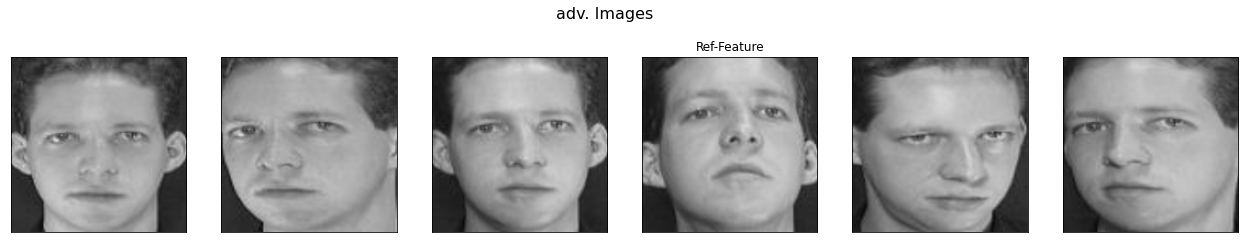

In [14]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

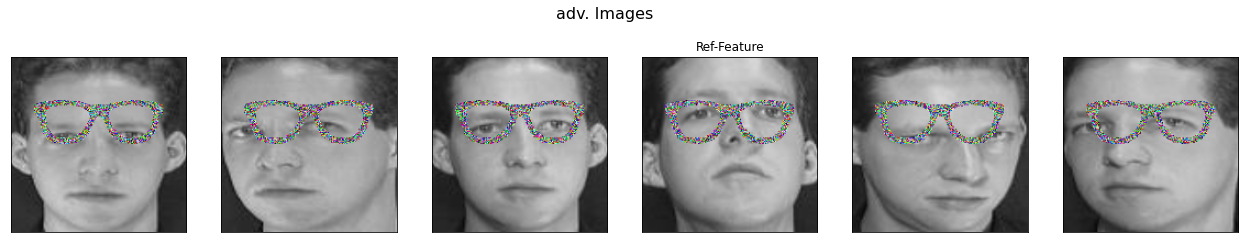

In [15]:
advImagesShow= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [16]:
# Tf Variables
advImages= tf.Variable(advImages, dtype=tf.float64)
Delta= tf.Variable(Delta, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
advRefFeature= tf.Variable(advRefFeature, dtype=tf.float32)

In [17]:
epoch= 400
Lambda= 0.2
for ep  in range(epoch+1):
    grad, loss= back_propagate(model, advImages, mask, Delta, advRefFeature, token= subjects.index(subjects[-1]))
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%10 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 851.507
Epoch: 10   Loss: 841.613
Epoch: 20   Loss: 831.884
Epoch: 30   Loss: 822.334
Epoch: 40   Loss: 812.975
Epoch: 50   Loss: 803.825
Epoch: 60   Loss: 794.900
Epoch: 70   Loss: 786.218
Epoch: 80   Loss: 777.800
Epoch: 90   Loss: 769.668
Epoch: 100   Loss: 761.849
Epoch: 110   Loss: 754.375
Epoch: 120   Loss: 747.275
Epoch: 130   Loss: 740.590
Epoch: 140   Loss: 734.351
Epoch: 150   Loss: 728.601
Epoch: 160   Loss: 723.370
Epoch: 170   Loss: 718.684
Epoch: 180   Loss: 714.559
Epoch: 190   Loss: 710.997
Epoch: 200   Loss: 707.970
Epoch: 210   Loss: 705.431
Epoch: 220   Loss: 703.314
Epoch: 230   Loss: 701.553
Epoch: 240   Loss: 700.090
Epoch: 250   Loss: 698.864
Epoch: 260   Loss: 697.834
Epoch: 270   Loss: 696.966
Epoch: 280   Loss: 696.235
Epoch: 290   Loss: 695.618
Epoch: 300   Loss: 695.097
Epoch: 310   Loss: 694.656
Epoch: 320   Loss: 694.283
Epoch: 330   Loss: 693.970
Epoch: 340   Loss: 693.705
Epoch: 350   Loss: 693.483
Epoch: 360   Loss: 693.296
Epoch: 370  

In [18]:
subjects.append('deltaAdvCentroid')
subjectsDict['deltaAdvCentroid']= get_RDM(model.predict(Generate_sample(advImages, Delta, mask)), token= subjects.index(subjects[-1]))
subjectsDict['deltaAdvCentroid'].shape

(10, 64)

In [19]:
flattened= np.vstack((flattened, subjectsDict['deltaAdvCentroid']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(60, 2)

In [20]:
KMEANS.predict(flattened)

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

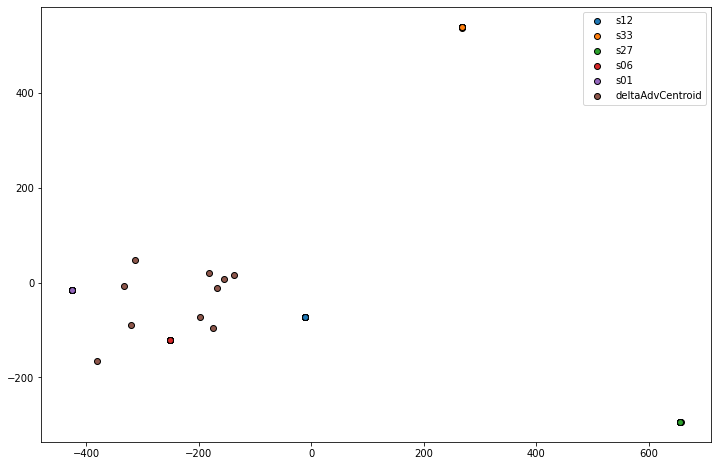

In [21]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+1):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

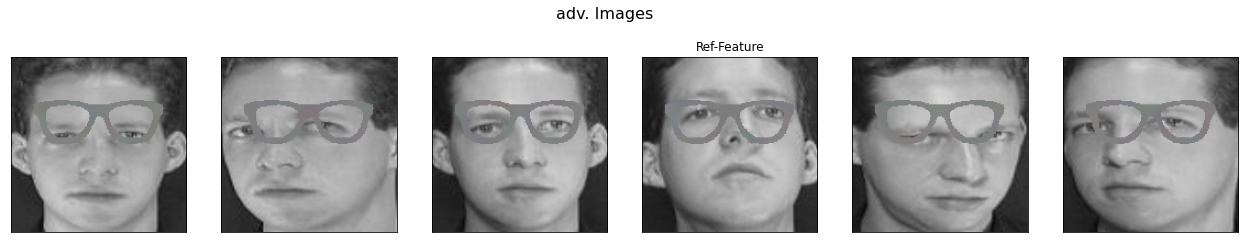

In [22]:
advImagesShow0= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

### Target Att....


In [23]:
tragetImages= load_data(glob.glob(imgDir+target+'/*'))
tragetFeature= model.predict(tragetImages)
tragetFeature= RDM_tf(tragetFeature, token= subjects.index(target))
tragetImages.shape, tragetFeature.shape

# advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
# advFeature= model.predict(advImages)
# Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
# advRefFeature= Generate_target(advFeature[5], batch_size=advImages.shape[0])
# advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), TensorShape([10, 64]))

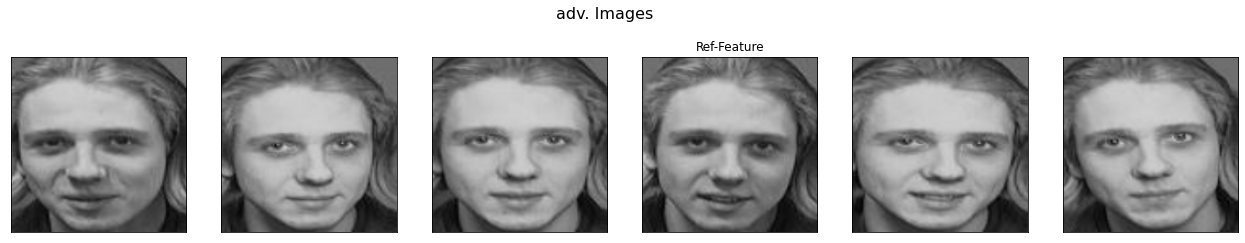

In [24]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(tragetImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [25]:
epoch= int(400 *2.5)
Lambda= 0.01
for ep  in range(epoch):
    grad, loss= back_propagate(model, advImages, mask, Delta, tragetFeature, token= subjects.index(target))
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%10 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 10.419
Epoch: 10   Loss: 10.415
Epoch: 20   Loss: 10.411
Epoch: 30   Loss: 10.407
Epoch: 40   Loss: 10.403
Epoch: 50   Loss: 10.399
Epoch: 60   Loss: 10.395
Epoch: 70   Loss: 10.391
Epoch: 80   Loss: 10.387
Epoch: 90   Loss: 10.384
Epoch: 100   Loss: 10.380
Epoch: 110   Loss: 10.376
Epoch: 120   Loss: 10.373
Epoch: 130   Loss: 10.369
Epoch: 140   Loss: 10.365
Epoch: 150   Loss: 10.362
Epoch: 160   Loss: 10.358
Epoch: 170   Loss: 10.355
Epoch: 180   Loss: 10.351
Epoch: 190   Loss: 10.348
Epoch: 200   Loss: 10.345
Epoch: 210   Loss: 10.341
Epoch: 220   Loss: 10.338
Epoch: 230   Loss: 10.335
Epoch: 240   Loss: 10.331
Epoch: 250   Loss: 10.328
Epoch: 260   Loss: 10.325
Epoch: 270   Loss: 10.322
Epoch: 280   Loss: 10.318
Epoch: 290   Loss: 10.315
Epoch: 300   Loss: 10.312
Epoch: 310   Loss: 10.309
Epoch: 320   Loss: 10.306
Epoch: 330   Loss: 10.303
Epoch: 340   Loss: 10.300
Epoch: 350   Loss: 10.297
Epoch: 360   Loss: 10.294
Epoch: 370   Loss: 10.291
Epoch: 380   Loss: 10.2

In [26]:
subjects.append('deltaTarget')
subjectsDict['deltaTarget']= get_RDM(model.predict(Generate_sample(advImages, Delta, mask)), token= subjects.index(subjects[-1]))
subjectsDict['deltaTarget'].shape

(10, 64)

In [27]:
flattened= np.vstack((flattened, subjectsDict['deltaTarget']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(70, 2)

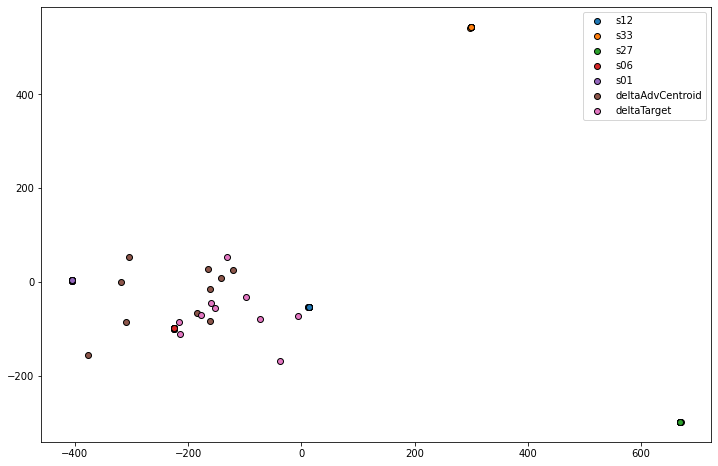

In [28]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+2):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [29]:
KMEANS.predict(flattened)

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1])

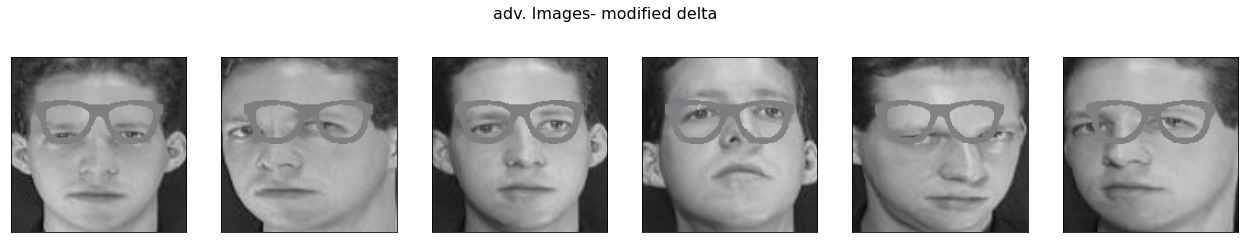

In [30]:
advImagesShow1= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images- modified delta", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow1[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()